## Maven Hospital Challenge

#### Challenge Objective

For the Maven Hospital Challenge, you'll play the role of an Analytics Consultant for Massachusetts General Hospital (MGH).

You've been asked to build a high-level KPI report for the executive team, based on a subset of patient records. The purpose of the report is to give stakeholders visibility into the hospital's recent performance, and answer the following questions:

 - How many patients have been admitted or readmitted over time?
 - How long are patients staying in the hospital, on average?
 - How much is the average cost per visit?
 - How many procedures are covered by insurance?

The dashboard should scale to accommodate new data over time, but the CEO has asked you to summarize any insights you can derive from the sample provided.

#### About The Data Set
Synthetic data on ~1k patients of Massachussets General Hospital from 2011-2022, including information on patient demographics, insurance coverage, and medical encounters & procedures.

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Let's import all the datasets required for this task
patient_encounters = pd.read_csv("encounters.csv")
# hospital_details = pd.read_csv("organizations.csv") No Need to import as there is only one hospital
patient_demographic = pd.read_csv("patients.csv")
insurance_payer = pd.read_csv("payers.csv")
operating_procedures = pd.read_csv("procedures.csv")

In [3]:
# Let's check the number of features and records each dataset has
print("patient encounters data:", patient_encounters.shape)
# print("hospital details:", hospital_details.shape)
print("patient demographic:", patient_demographic.shape)
print("insurance payer:", insurance_payer.shape)
print("operating procedures:", operating_procedures.shape)

patient encounters data: (27891, 14)
patient demographic: (974, 20)
insurance payer: (10, 7)
operating procedures: (47701, 9)


In [4]:
# remove columns that are not necesssary for our analysis from patient_encounters
patient_encounters = patient_encounters.drop(['ORGANIZATION'], axis=1)

# remove columns that are not necesssary for our analysis from patient_demographic
patient_demographic = patient_demographic.drop(['PREFIX', 'SUFFIX', 'MAIDEN', 'BIRTHPLACE', 'ADDRESS', 'STATE', 'ZIP'], axis=1)

# remove columns that are not necesssary for our analysis from insurance_payer
insurance_payer = insurance_payer.drop(['ADDRESS', 'CITY', 'STATE_HEADQUARTERED', 'ZIP', 'PHONE'], axis=1)

In [5]:
# Let's look at some few records from each dataset
print("patient encounters:")
patient_encounters.head(5)

patient encounters:


,Id,START,STOP,PATIENT,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,32c84703-2481-49cd-d571-3899d5820253,2011-01-02T09:26:36Z,2011-01-02T12:58:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,185347001,Encounter for problem (procedure),85.55,1018.02,0.00,NaN,NaN
1,c98059da-320a-c0a6-fced-c8815f3e3f39,2011-01-03T05:44:39Z,2011-01-03T06:01:42Z,d9ec2e44-32e9-9148-179a-1653348cc4e2,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,outpatient,308335008,Patient encounter procedure,142.58,2619.36,0.00,NaN,NaN
2,4ad28a3a-2479-782b-f29c-d5b3f41a001e,2011-01-03T14:32:11Z,2011-01-03T14:47:11Z,73babadf-5b2b-fee7-189e-6f41ff213e01,7caa7254-5050-3b5e-9eae-bd5ea30e809c,outpatient,185349003,Encounter for check up (procedure),85.55,461.59,305.27,NaN,NaN
3,c3f4da61-e4b4-21d5-587a-fbc89943bc19,2011-01-03T16:24:45Z,2011-01-03T16:39:45Z,3b46a0b7-0f34-9b9a-c319-ace4a1f58c0b,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,wellness,162673000,General examination of patient (procedure),136.80,1784.24,0.00,NaN,NaN
4,a9183b4f-2572-72ea-54c2-b3cd038b4be7,2011-01-03T17:36:53Z,2011-01-03T17:51:53Z,fa006887-d93c-d302-8b89-f3c25f88c0e1,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,ambulatory,390906007,Follow-up encounter,85.55,234.72,0.00,55822004.0,Hyperlipidemia


In [6]:
print("patient demographic:")
patient_demographic.head(5)

patient demographic:


,Id,BIRTHDATE,DEATHDATE,FIRST,LAST,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,LAT,LON
0,5605b66b-e92d-c16c-1b83-b8bf7040d51f,1977-03-19,NaN,Nikita578,Erdman779,M,white,nonhispanic,F,Quincy,Norfolk County,42.290937,-70.975503
1,6e5ae27c-8038-7988-e2c0-25a103f01bfa,1940-02-19,NaN,Zane918,Hodkiewicz467,M,white,nonhispanic,M,Boston,Suffolk County,42.308831,-71.063162
2,8123d076-0886-9007-e956-d5864aa121a7,1958-06-04,NaN,Quinn173,Marquardt819,M,white,nonhispanic,M,Quincy,Norfolk County,42.265177,-70.967085
3,770518e4-6133-648e-60c9-071eb2f0e2ce,1928-12-25,2017-09-29,Abel832,Smitham825,M,white,hispanic,M,Boston,Suffolk County,42.334304,-71.066801
4,f96addf5-81b9-0aab-7855-d208d3d352c5,1928-12-25,2014-02-23,Edwin773,Labadie908,M,white,hispanic,M,Boston,Suffolk County,42.346771,-71.058813


In [7]:
print("insurance payer:")
insurance_payer.head(10)

insurance payer:


,Id,NAME
0,b3221cfc-24fb-339e-823d-bc4136cbc4ed,Dual Eligible
1,7caa7254-5050-3b5e-9eae-bd5ea30e809c,Medicare
2,7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a,Medicaid
3,d47b3510-2895-3b70-9897-342d681c769d,Humana
4,6e2f1a2d-27bd-3701-8d08-dae202c58632,Blue Cross Blue Shield
5,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,UnitedHealthcare
6,4d71f845-a6a9-3c39-b242-14d25ef86a8d,Aetna
7,047f6ec3-6215-35eb-9608-f9dda363a44c,Cigna Health
8,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,Anthem
9,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,NO_INSURANCE


In [8]:
print("operating procedures:") 
operating_procedures.head(5)

operating procedures:


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2011-01-02T09:26:36Z,2011-01-02T12:58:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,32c84703-2481-49cd-d571-3899d5820253,265764009,Renal dialysis (procedure),903,NaN,NaN
1,2011-01-03T05:44:39Z,2011-01-03T06:01:42Z,d9ec2e44-32e9-9148-179a-1653348cc4e2,c98059da-320a-c0a6-fced-c8815f3e3f39,76601001,Intramuscular injection,2477,NaN,NaN
2,2011-01-04T14:49:55Z,2011-01-04T15:04:55Z,d856d6e6-4c98-e7a2-129b-44076c63d008,2cfd4ddd-ad13-fe1e-528b-15051cea2ec3,703423002,Combined chemotherapy and radiation therapy (p...,11620,363406005.0,Malignant tumor of colon
3,2011-01-05T04:02:09Z,2011-01-05T04:17:09Z,bc9d59c3-0a30-6e3b-f47d-022e4f03c8de,17966936-0878-f4db-128b-a43ae10d0878,173160006,Diagnostic fiberoptic bronchoscopy (procedure),9796,162573006.0,Suspected lung cancer (situation)
4,2011-01-05T12:58:36Z,2011-01-05T16:42:36Z,3de74169-7f67-9304-91d4-757e0f3a14d2,9de5f0b0-4ba4-ce6f-45fb-b55c202f31a5,265764009,Renal dialysis (procedure),1255,NaN,NaN


In [9]:
# Let's check the datatypes present
print("patient encounters:")
patient_encounters.dtypes

patient encounters:


Id                      object
START                   object
STOP                    object
PATIENT                 object
PAYER                   object
ENCOUNTERCLASS          object
CODE                     int64
DESCRIPTION             object
BASE_ENCOUNTER_COST    float64
TOTAL_CLAIM_COST       float64
PAYER_COVERAGE         float64
REASONCODE             float64
REASONDESCRIPTION       object
dtype: object

In [10]:
print("patient demographic:")
patient_demographic.dtypes

patient demographic:


Id            object
BIRTHDATE     object
DEATHDATE     object
FIRST         object
LAST          object
MARITAL       object
RACE          object
ETHNICITY     object
GENDER        object
CITY          object
COUNTY        object
LAT          float64
LON          float64
dtype: object

In [11]:
print("insurance payer:")
insurance_payer.dtypes

insurance payer:


Id      object
NAME    object
dtype: object

In [12]:
print("operating procedures:") 
operating_procedures.dtypes

operating procedures:


START                 object
STOP                  object
PATIENT               object
ENCOUNTER             object
CODE                   int64
DESCRIPTION           object
BASE_COST              int64
REASONCODE           float64
REASONDESCRIPTION     object
dtype: object

In [13]:
# first we will convert some columns to proper datatypes
# patient_encounters
patient_encounters["START"] = pd.to_datetime(patient_encounters["START"]).dt.tz_localize(None)
patient_encounters["STOP"] = pd.to_datetime(patient_encounters["STOP"]).dt.tz_localize(None)
patient_encounters["CODE"] = patient_encounters["CODE"].astype("object")
patient_encounters["REASONCODE"] = patient_encounters["REASONCODE"].astype("object")

# hospital_details
# hospital_details["ZIP"] = hospital_details["ZIP"].astype("object")
# hospital_details["LAT"] = hospital_details["LAT"].astype("object")
# hospital_details["LON"] = hospital_details["LON"].astype("object")

# patient_demographic
patient_demographic["BIRTHDATE"] = pd.to_datetime(patient_demographic["BIRTHDATE"], format='%Y-%m-%d')
patient_demographic["DEATHDATE"] = pd.to_datetime(patient_demographic["DEATHDATE"], format='%Y-%m-%d')
patient_demographic["LAT"] = patient_demographic["LAT"].astype("object")
patient_demographic["LON"] = patient_demographic["LON"].astype("object")

# operating_procedures
operating_procedures["START"] = pd.to_datetime(operating_procedures["START"]).dt.tz_localize(None)
operating_procedures["STOP"] = pd.to_datetime(operating_procedures["STOP"]).dt.tz_localize(None)
operating_procedures["CODE"] = operating_procedures["CODE"].astype("object")
operating_procedures["REASONCODE"] = operating_procedures["REASONCODE"].astype("object")

In [14]:
# Descriptive Statistics
print("patient encounters:")
patient_encounters.describe(include="all").T

patient encounters:


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Id,27891,27891,32c84703-2481-49cd-d571-3899d5820253,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
START,27891,27541,2016-12-08 10:00:40,3,2011-01-02 09:26:36,2022-02-05 20:27:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STOP,27891,27765,2016-12-08 10:15:40,3,2011-01-02 12:58:36,2022-02-05 20:42:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT,27891,974,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1381,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAYER,27891,10,7caa7254-5050-3b5e-9eae-bd5ea30e809c,11371,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTERCLASS,27891,6,ambulatory,12537,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,27891.0,45.0,185347001.0,5261.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESCRIPTION,27891,53,Encounter for problem (procedure),4308,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_ENCOUNTER_COST,27891.0,NaN,NaN,NaN,NaT,NaT,116.181614,28.410082,85.55,85.55,136.8,142.58,146.18
TOTAL_CLAIM_COST,27891.0,NaN,NaN,NaN,NaT,NaT,3639.682174,9205.595748,0.0,142.58,278.58,1412.53,641882.7


In [15]:
print("patient demographic:") 
patient_demographic.describe(include="all").T

patient demographic:


,count,unique,top,freq,first,last
Id,974,974,5605b66b-e92d-c16c-1b83-b8bf7040d51f,1,NaT,NaT
BIRTHDATE,974,880,1925-11-17 00:00:00,4,1922-03-24,1991-11-27
DEATHDATE,154,148,2017-09-29 00:00:00,2,2011-02-03,2022-01-27
FIRST,974,842,Domenic627,3,NaT,NaT
LAST,974,498,Heaney114,6,NaT,NaT
MARITAL,973,2,M,784,NaT,NaT
RACE,974,6,white,680,NaT,NaT
ETHNICITY,974,2,nonhispanic,783,NaT,NaT
GENDER,974,2,M,494,NaT,NaT
CITY,974,29,Boston,541,NaT,NaT


In [16]:
print("insurance payer:")
insurance_payer.describe(include="all").T

insurance payer:


,count,unique,top,freq
Id,10,10,b3221cfc-24fb-339e-823d-bc4136cbc4ed,1
NAME,10,10,Dual Eligible,1


In [17]:
print("operating procedures:") 
operating_procedures.describe(include="all").T

operating procedures:


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
START,47701,39251,2013-09-30 22:31:23,21,2011-01-02 09:26:36,2022-01-29 20:35:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STOP,47701,42263,2019-03-12 08:27:16,20,2011-01-02 12:58:36,2022-01-29 21:08:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT,47701,793,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1783,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTER,47701,14670,66b2ab44-a2cc-8053-8f4e-c5be57e50cc4,186,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,47701.0,157.0,710824005.0,4596.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESCRIPTION,47701,163,Assessment of health and social care needs (pr...,4596,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_COST,47701.0,NaN,NaN,NaN,NaT,NaT,2212.064967,5572.978748,1.0,431.0,431.0,966.0,289531.0
REASONCODE,10756.0,46.0,72892002.0,5718.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REASONDESCRIPTION,10756,46,Normal pregnancy,5718,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Let's look at the concise information on each dataset
print("patient encounters:")
patient_encounters.info()

patient encounters:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27891 entries, 0 to 27890
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   27891 non-null  object        
 1   START                27891 non-null  datetime64[ns]
 2   STOP                 27891 non-null  datetime64[ns]
 3   PATIENT              27891 non-null  object        
 4   PAYER                27891 non-null  object        
 5   ENCOUNTERCLASS       27891 non-null  object        
 6   CODE                 27891 non-null  object        
 7   DESCRIPTION          27891 non-null  object        
 8   BASE_ENCOUNTER_COST  27891 non-null  float64       
 9   TOTAL_CLAIM_COST     27891 non-null  float64       
 10  PAYER_COVERAGE       27891 non-null  float64       
 11  REASONCODE           8350 non-null   object        
 12  REASONDESCRIPTION    8350 non-null   object        
dtypes: datetime

In [19]:
print("patient demographic:") 
patient_demographic.info()

patient demographic:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Id         974 non-null    object        
 1   BIRTHDATE  974 non-null    datetime64[ns]
 2   DEATHDATE  154 non-null    datetime64[ns]
 3   FIRST      974 non-null    object        
 4   LAST       974 non-null    object        
 5   MARITAL    973 non-null    object        
 6   RACE       974 non-null    object        
 7   ETHNICITY  974 non-null    object        
 8   GENDER     974 non-null    object        
 9   CITY       974 non-null    object        
 10  COUNTY     974 non-null    object        
 11  LAT        974 non-null    object        
 12  LON        974 non-null    object        
dtypes: datetime64[ns](2), object(11)
memory usage: 99.0+ KB


In [20]:
# handle missing data in MARITAL column
patient_demographic.fillna({'MARITAL':'M'}, inplace=True)

In [21]:
print("insurance payer:")
insurance_payer.info()

insurance payer:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      10 non-null     object
 1   NAME    10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [22]:
print("operating procedures:") 
operating_procedures.info()

operating procedures:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47701 entries, 0 to 47700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   START              47701 non-null  datetime64[ns]
 1   STOP               47701 non-null  datetime64[ns]
 2   PATIENT            47701 non-null  object        
 3   ENCOUNTER          47701 non-null  object        
 4   CODE               47701 non-null  object        
 5   DESCRIPTION        47701 non-null  object        
 6   BASE_COST          47701 non-null  int64         
 7   REASONCODE         10756 non-null  object        
 8   REASONDESCRIPTION  10756 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.3+ MB


So, after spending a lot of time merging the datasets together and analyzing them, I found an optimal solution which needs two datasets:
 - encounters_data - merging (patient_encounters, patient_demographic, insurance_payer) &
 - procedures_data - merging (encounters_data, operating_procedures).

The reason behind creating 2 datasets is the difference in number of patient's going for procedures and the ones not going for procedures. There are 181 patient's who have not undergone any procedures that are in the procedures data. So, we hava to analyze two datasets.

In [23]:
# Merge encounters with patients
encounters_patients = pd.merge(patient_encounters, patient_demographic, left_on='PATIENT', right_on='Id', how='inner', suffixes=('_enc', '_pat'))
# Merge the result with payers
enc_data = pd.merge(encounters_patients, insurance_payer, left_on='PAYER', right_on='Id', how='inner', suffixes=('', '_pay'))
# drop unnecessary columns
enc_data = enc_data.drop(['Id_pat', 'Id'], axis=1)

In [24]:
# Rename columns for clarity and consistency
enc_data.rename(columns={
    'Id_enc': 'ENCOUNTER_ID',
    'PATIENT': 'PATIENT_ID',
    'PAYER': 'PAYER_ID',
    'NAME': 'PAYER_NAME'
}, inplace=True)

In [25]:
# To calculate the age of patient's define the reference date as the last day of 2021 as there are very few records of the year 2022
from datetime import datetime
reference_date = datetime(2021, 12, 31)

# Calculate age for patients who are alive as of the end of 2021
enc_data['Age_at_2021_End'] = (reference_date - enc_data['BIRTHDATE']).dt.days // 365

# Calculate age at the time of death for patients who have a DEATHDATE
enc_data['Age_at_Death'] = (enc_data['DEATHDATE'] - enc_data['BIRTHDATE']).dt.days // 365

# Replace NaN in 'Age_at_Death' with the 'Age_at_2021_End' where applicable
enc_data['AGE'] = enc_data['Age_at_Death'].fillna(enc_data['Age_at_2021_End'])

# Drop the temporary columns used for calculation
enc_data.drop(columns=['Age_at_2021_End', 'Age_at_Death'], inplace=True)

In [26]:
# create a column ENCOUNTER_DURATION to calculate the total duration of the encounter in hours
enc_data['ENCOUNTER_DURATION'] = (((enc_data['STOP'] - enc_data['START']).dt.total_seconds())/3600).round(2)

In [27]:
# check column names
enc_data.columns

Index(['ENCOUNTER_ID', 'START', 'STOP', 'PATIENT_ID', 'PAYER_ID',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'CITY', 'COUNTY', 'LAT', 'LON', 'PAYER_NAME',
       'AGE', 'ENCOUNTER_DURATION'],
      dtype='object')

In [28]:
# check for duplicates
enc_data.duplicated().sum()

0

In [29]:
# check for null records
enc_data.isnull().sum()

ENCOUNTER_ID               0
START                      0
STOP                       0
PATIENT_ID                 0
PAYER_ID                   0
ENCOUNTERCLASS             0
CODE                       0
DESCRIPTION                0
BASE_ENCOUNTER_COST        0
TOTAL_CLAIM_COST           0
PAYER_COVERAGE             0
REASONCODE             19541
REASONDESCRIPTION      19541
BIRTHDATE                  0
DEATHDATE              23053
FIRST                      0
LAST                       0
MARITAL                    0
RACE                       0
ETHNICITY                  0
GENDER                     0
CITY                       0
COUNTY                     0
LAT                        0
LON                        0
PAYER_NAME                 0
AGE                        0
ENCOUNTER_DURATION         0
dtype: int64

In [30]:
# check number of records and features 
enc_data.shape

(27891, 28)

In [31]:
# check datatypes
enc_data.dtypes

ENCOUNTER_ID                   object
START                  datetime64[ns]
STOP                   datetime64[ns]
PATIENT_ID                     object
PAYER_ID                       object
ENCOUNTERCLASS                 object
CODE                           object
DESCRIPTION                    object
BASE_ENCOUNTER_COST           float64
TOTAL_CLAIM_COST              float64
PAYER_COVERAGE                float64
REASONCODE                     object
REASONDESCRIPTION              object
BIRTHDATE              datetime64[ns]
DEATHDATE              datetime64[ns]
FIRST                          object
LAST                           object
MARITAL                        object
RACE                           object
ETHNICITY                      object
GENDER                         object
CITY                           object
COUNTY                         object
LAT                            object
LON                            object
PAYER_NAME                     object
AGE         

In [32]:
# descriptive statistics
enc_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ENCOUNTER_ID,27891,27891,32c84703-2481-49cd-d571-3899d5820253,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
START,27891,27541,2016-12-08 10:00:40,3,2011-01-02 09:26:36,2022-02-05 20:27:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STOP,27891,27765,2016-12-08 10:15:40,3,2011-01-02 12:58:36,2022-02-05 20:42:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT_ID,27891,974,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1381,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAYER_ID,27891,10,7caa7254-5050-3b5e-9eae-bd5ea30e809c,11371,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTERCLASS,27891,6,ambulatory,12537,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE,27891.0,45.0,185347001.0,5261.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESCRIPTION,27891,53,Encounter for problem (procedure),4308,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_ENCOUNTER_COST,27891.0,NaN,NaN,NaN,NaT,NaT,116.181614,28.410082,85.55,85.55,136.8,142.58,146.18
TOTAL_CLAIM_COST,27891.0,NaN,NaN,NaN,NaT,NaT,3639.682174,9205.595748,0.0,142.58,278.58,1412.53,641882.7


In [33]:
# Merge the result with procedures
proc_data = pd.merge(enc_data, operating_procedures, left_on=['ENCOUNTER_ID', 'PATIENT_ID'], right_on=['ENCOUNTER','PATIENT'], 
                     how='inner', suffixes=('', '_proc'))

# Remove duplicate columns if necessary
proc_data = proc_data.loc[:,~proc_data.columns.duplicated()]

In [34]:
proc_data.columns

Index(['ENCOUNTER_ID', 'START', 'STOP', 'PATIENT_ID', 'PAYER_ID',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'CITY', 'COUNTY', 'LAT', 'LON', 'PAYER_NAME',
       'AGE', 'ENCOUNTER_DURATION', 'START_proc', 'STOP_proc', 'PATIENT',
       'ENCOUNTER', 'CODE_proc', 'DESCRIPTION_proc', 'BASE_COST',
       'REASONCODE_proc', 'REASONDESCRIPTION_proc'],
      dtype='object')

In [35]:
# Remove duplicate columns by selecting only one version of them and unnecessary columns 
proc_data = proc_data.drop(columns=['ENCOUNTER', 'PATIENT', 'START', 'STOP', 'AGE', 'ENCOUNTER_DURATION'])

# Rename columns for clarity and consistency
proc_data.rename(columns={
    'CODE': 'Encounter_Code',
    'DESCRIPTION': 'Encounter_Description',
    'BASE_COST': 'BASECOST_proc',
}, inplace=True)

In [36]:
# To calculate the age of patient's define the reference date as the last day of 2021 as there are very few records of the year 2022
from datetime import datetime
reference_date = datetime(2021, 12, 31)

# Calculate age for patients who are alive as of the end of 2021
proc_data['Age_at_2021_End'] = (reference_date - proc_data['BIRTHDATE']).dt.days // 365

# Calculate age at the time of death for patients who have a DEATHDATE
proc_data['Age_at_Death'] = (proc_data['DEATHDATE'] - proc_data['BIRTHDATE']).dt.days // 365

# Replace NaN in 'Age_at_Death' with the 'Age_at_2021_End' where applicable
proc_data['AGE'] = proc_data['Age_at_Death'].fillna(proc_data['Age_at_2021_End'])

# Drop the temporary columns used for calculation
proc_data.drop(columns=['Age_at_2021_End', 'Age_at_Death'], inplace=True)

In [37]:
# Also let's add a column that calculates the procedure duration in hours
# Procedure Duration
proc_data['Duration_proc'] = (((proc_data['START_proc'] - proc_data['STOP_proc']).dt.total_seconds())/3600).round(2)

In [38]:
# check for duplicate records
proc_data.duplicated().sum()

0

In [39]:
# check for missing records
proc_data.isnull().sum()

ENCOUNTER_ID                  0
PATIENT_ID                    0
PAYER_ID                      0
ENCOUNTERCLASS                0
Encounter_Code                0
Encounter_Description         0
BASE_ENCOUNTER_COST           0
TOTAL_CLAIM_COST              0
PAYER_COVERAGE                0
REASONCODE                34411
REASONDESCRIPTION         34411
BIRTHDATE                     0
DEATHDATE                 38207
FIRST                         0
LAST                          0
MARITAL                       0
RACE                          0
ETHNICITY                     0
GENDER                        0
CITY                          0
COUNTY                        0
LAT                           0
LON                           0
PAYER_NAME                    0
START_proc                    0
STOP_proc                     0
CODE_proc                     0
DESCRIPTION_proc              0
BASECOST_proc                 0
REASONCODE_proc           36945
REASONDESCRIPTION_proc    36945
AGE     

In [40]:
# check number of records and features 
proc_data.shape

(47701, 33)

In [41]:
# check datatypes
proc_data.dtypes

ENCOUNTER_ID                      object
PATIENT_ID                        object
PAYER_ID                          object
ENCOUNTERCLASS                    object
Encounter_Code                    object
Encounter_Description             object
BASE_ENCOUNTER_COST              float64
TOTAL_CLAIM_COST                 float64
PAYER_COVERAGE                   float64
REASONCODE                        object
REASONDESCRIPTION                 object
BIRTHDATE                 datetime64[ns]
DEATHDATE                 datetime64[ns]
FIRST                             object
LAST                              object
MARITAL                           object
RACE                              object
ETHNICITY                         object
GENDER                            object
CITY                              object
COUNTY                            object
LAT                               object
LON                               object
PAYER_NAME                        object
START_proc      

In [42]:
# descriptive statistics
proc_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ENCOUNTER_ID,47701,14670,66b2ab44-a2cc-8053-8f4e-c5be57e50cc4,186,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATIENT_ID,47701,793,1712d26d-822d-1e3a-2267-0a9dba31d7c8,1783,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAYER_ID,47701,10,7caa7254-5050-3b5e-9eae-bd5ea30e809c,19512,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENCOUNTERCLASS,47701,6,ambulatory,17822,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Encounter_Code,47701.0,37.0,185349003.0,14304.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Encounter_Description,47701,44,Encounter for check up (procedure),13510,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_ENCOUNTER_COST,47701.0,NaN,NaN,NaN,NaT,NaT,110.397706,27.366963,85.55,85.55,85.55,142.58,146.18
TOTAL_CLAIM_COST,47701.0,NaN,NaN,NaN,NaT,NaT,8306.261995,18477.586417,0.0,385.73,1139.82,10627.57,641882.7
PAYER_COVERAGE,47701.0,NaN,NaN,NaN,NaT,NaT,3057.640727,10957.346681,0.0,0.0,36.44,718.74,247751.42
REASONCODE,13290.0,43.0,72892002.0,5686.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# save the datasets
enc_data.to_csv("enc_data.csv", index=False)
proc_data.to_csv("proc_data.csv", index=False)

#### Exploratory Data Analysis on Encounters Data

In [44]:
enc_data.columns

Index(['ENCOUNTER_ID', 'START', 'STOP', 'PATIENT_ID', 'PAYER_ID',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'CITY', 'COUNTY', 'LAT', 'LON', 'PAYER_NAME',
       'AGE', 'ENCOUNTER_DURATION'],
      dtype='object')

In [45]:
# Total number of encounters
print("Total Encounters:", enc_data.shape[0])
# Unique number of patients
print("Unique Patient's:", enc_data['PATIENT_ID'].nunique())
# Number of Insurance Payers
print("Insurance Payers:", enc_data[enc_data['PAYER_NAME']!='NO_INSURANCE'].nunique()[4])
# Encounter class types
print("Encounter class types:", enc_data['ENCOUNTERCLASS'].nunique())

Total Encounters: 27891
Unique Patient's: 974
Insurance Payers: 9
Encounter class types: 6


#### Univariate Analysis

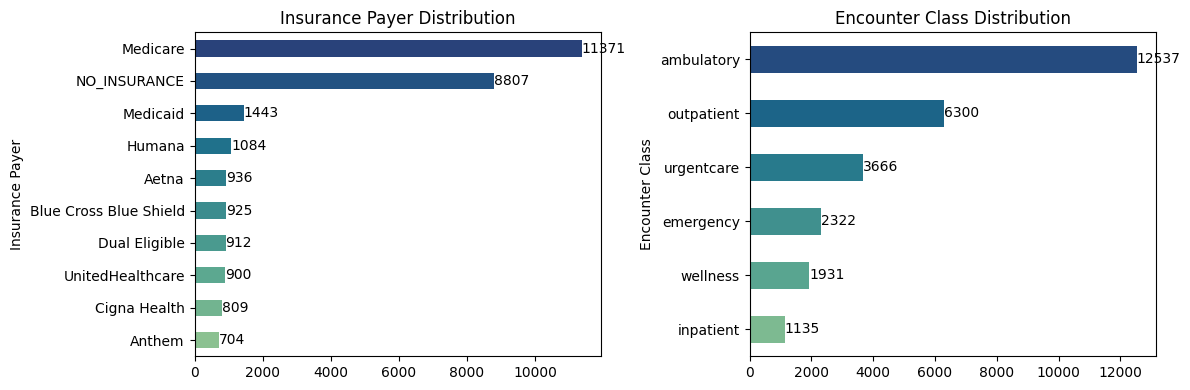

In [46]:
# Insurance Payer and Encounter Class 

plt.figure(figsize=(12, 4))
palette1 = sns.color_palette("crest", len(enc_data['PAYER_NAME'].unique()))
palette2 = sns.color_palette("crest", len(enc_data['ENCOUNTERCLASS'].unique()))

# Insurance Payer
ax1 = plt.subplot2grid((1,2), (0,0))
enc_data['PAYER_NAME'].value_counts().sort_values(ascending=True).plot(kind='barh', xlabel='Insurance Payer', ylabel='counts', 
                                                                       color=palette1, ax=ax1)
for i in ax1.containers:
    plt.bar_label(i)
plt.title("Insurance Payer Distribution")

# Encounter Class
ax2 = plt.subplot2grid((1,2), (0,1))
enc_data['ENCOUNTERCLASS'].value_counts().sort_values(ascending=True).plot(kind='barh', xlabel='Encounter Class', ylabel='counts', 
                                                                       color=palette2, ax=ax2)
for i in ax2.containers:
    plt.bar_label(i)
plt.title("Encounter Class Distribution")

plt.tight_layout()
plt.show()

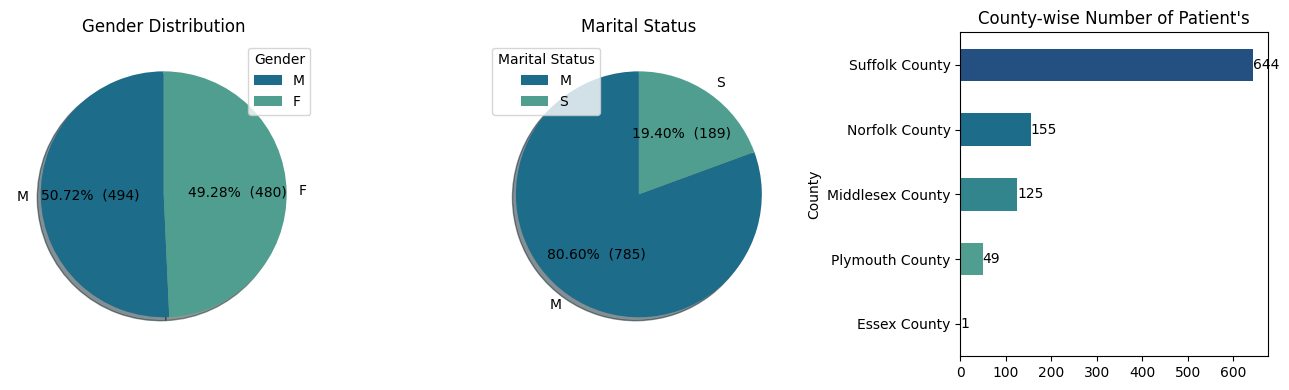

In [47]:
# Patient Demographic

plt.figure(figsize=(13, 4))
palette1 = sns.color_palette("crest_r", len(patient_demographic['GENDER'].unique()))
palette2 = sns.color_palette("crest_r", len(patient_demographic['MARITAL'].unique()))
palette3 = sns.color_palette("crest", len(patient_demographic['COUNTY'].unique()))

# Gender Distribution
ax1 = plt.subplot2grid((1,3), (0,0))
dataGender = patient_demographic['GENDER'].value_counts().values
labelsGender = patient_demographic['GENDER'].value_counts().index

plt.pie(x=dataGender, labels=labelsGender, startangle=90,
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(dataGender)/100), colors=palette1, shadow=True)
plt.legend(labelsGender, loc='upper right', title='Gender')
plt.title("Gender Distribution")

# Marital Status
ax2 = plt.subplot2grid((1,3), (0,1))
dataMarital = patient_demographic['MARITAL'].value_counts().values
labelsMarital = patient_demographic['MARITAL'].value_counts().index

plt.pie(x=dataMarital, labels=labelsMarital, startangle=90,
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(dataMarital)/100), colors=palette2, shadow=True)
plt.legend(labelsMarital, loc='upper left', title='Marital Status')
plt.title("Marital Status")

# County-wise Number of Patient's
ax3 = plt.subplot2grid((1,3), (0,2))
patient_demographic['COUNTY'].value_counts().sort_values(ascending=True).plot(kind='barh', xlabel='County', ylabel='counts', 
                                                                       color=palette3, ax=ax3)
for i in ax3.containers:
    plt.bar_label(i)
plt.title("County-wise Number of Patient's")

plt.tight_layout()
plt.show()

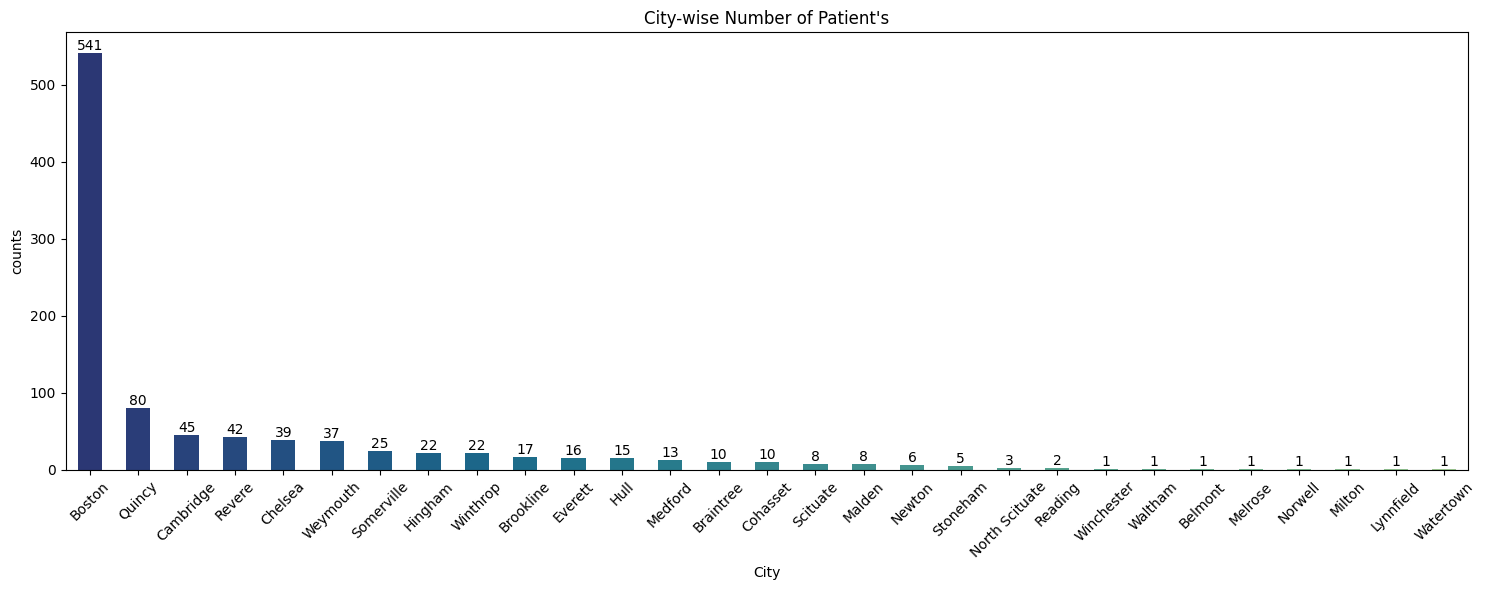

In [48]:
# City-wise Number of Patient's

plt.figure(figsize=(15, 6))
palette1 = sns.color_palette("crest_r", len(patient_demographic['CITY'].unique()))

# County Distribution
ax1 = plt.subplot2grid((1,1), (0,0))
patient_demographic['CITY'].value_counts().sort_values(ascending=False).plot(kind='bar', xlabel='City', ylabel='counts', 
                                                                       color=palette1, ax=ax1)
for i in ax1.containers:
    plt.bar_label(i)
plt.xticks(rotation=45)
plt.title("City-wise Number of Patient's")

plt.tight_layout()
plt.show()

In [49]:
patient_demographic['CITY'].value_counts().sort_values(ascending=False)

Boston            541
Quincy             80
Cambridge          45
Revere             42
Chelsea            39
Weymouth           37
Somerville         25
Hingham            22
Winthrop           22
Brookline          17
Everett            16
Hull               15
Medford            13
Braintree          10
Cohasset           10
Scituate            8
Malden              8
Newton              6
Stoneham            5
North Scituate      3
Reading             2
Winchester          1
Waltham             1
Belmont             1
Melrose             1
Norwell             1
Milton              1
Lynnfield           1
Watertown           1
Name: CITY, dtype: int64

In [50]:
# To calculate the age of patient's define the reference date as the last day of 2021 as there are very few records of the year 2022
from datetime import datetime
reference_date = datetime(2021, 12, 31)

# Calculate age for patients who are alive as of the end of 2021
patient_demographic['Age_at_2021_End'] = (reference_date - patient_demographic['BIRTHDATE']).dt.days // 365

# Calculate age at the time of death for patients who have a DEATHDATE
patient_demographic['Age_at_Death'] = (patient_demographic['DEATHDATE'] - patient_demographic['BIRTHDATE']).dt.days // 365

# Replace NaN in 'Age_at_Death' with the 'Age_at_2021_End' where applicable
patient_demographic['AGE'] = patient_demographic['Age_at_Death'].fillna(patient_demographic['Age_at_2021_End'])

# Drop the temporary columns used for calculation
patient_demographic.drop(columns=['Age_at_2021_End', 'Age_at_Death'], inplace=True)

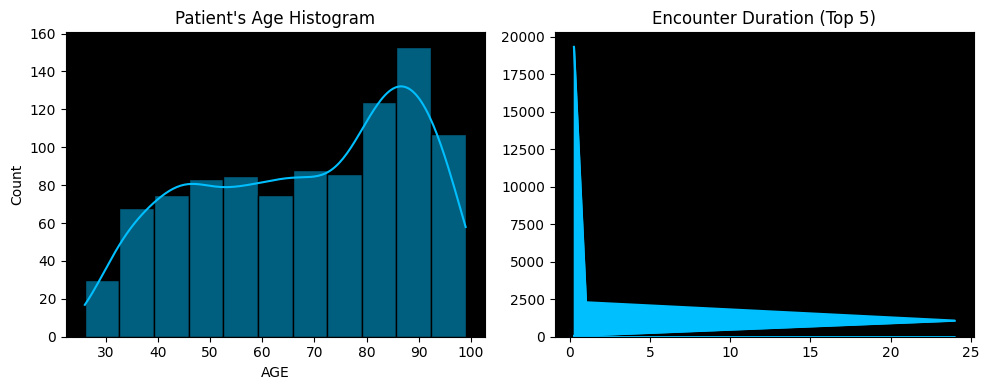

In [51]:
plt.figure(figsize=(10,4))

# Patient's Age Histogram

ax1 = plt.subplot2grid((1,2), (0,0))
ax1.set_facecolor('black')
sns.histplot(data=patient_demographic, x='AGE', kde='True', element='bars', color='deepskyblue', ax=ax1)
plt.title("Patient's Age Histogram")

# Encounter Duration (Top 5)

ax2 = plt.subplot2grid((1,2),(0,1))
ax2.set_facecolor('black')
enc_data['ENCOUNTER_DURATION'].value_counts().head().plot(kind='area', ax=ax2, color='deepskyblue')
plt.title("Encounter Duration (Top 5)")

plt.tight_layout()
plt.show()

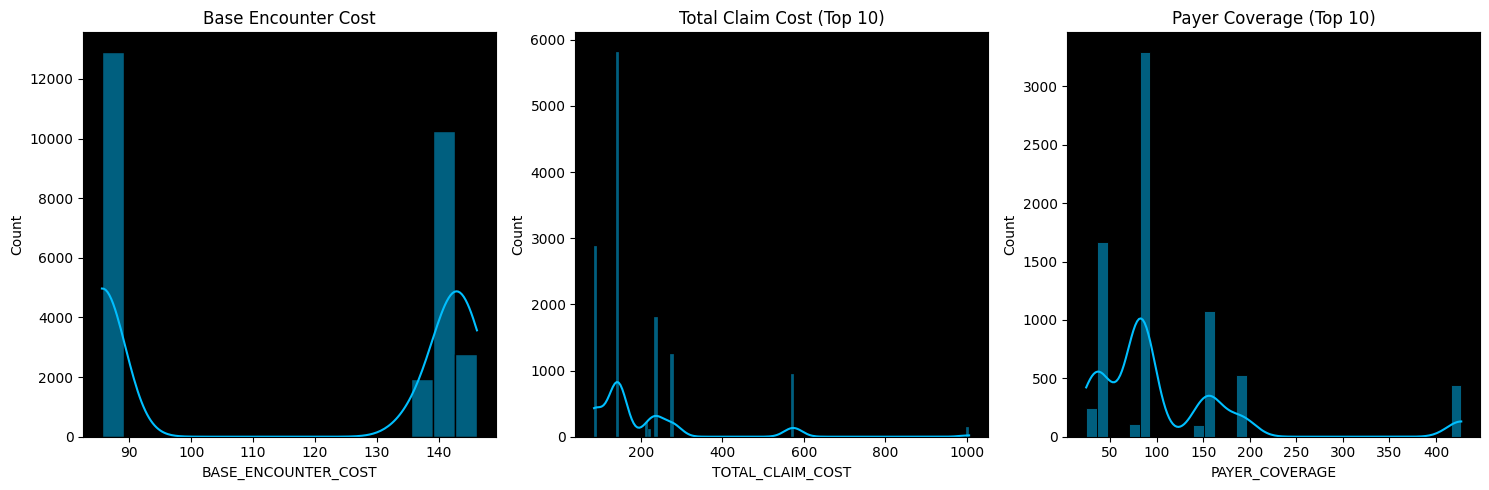

In [52]:
# Base Encounter Cost, Total Claim Cost, Payer Coverage Distribution
plt.figure(figsize=(15,5))

# Base Encounter Cost

BaseEncCost = enc_data[enc_data['BASE_ENCOUNTER_COST']>0]

ax1 = plt.subplot2grid((1,3),(0,0))
ax1.set_facecolor('black')
sns.histplot(data=BaseEncCost,x='BASE_ENCOUNTER_COST', kde='True', color='deepskyblue', ax=ax1, stat='count')
plt.title("Base Encounter Cost")

# Total Claim Cost (Top 10)

TotClaim = enc_data[enc_data['TOTAL_CLAIM_COST'].isin([142.58, 85.55, 234.72, 146.18, 278.58, 573.98, 234.71, 215.49, 1005.38, 221.55])]

ax2 = plt.subplot2grid((1,3),(0,1))
ax2.set_facecolor('black')
sns.histplot(data=TotClaim, x='TOTAL_CLAIM_COST', kde=True, color='deepskyblue', ax=ax2, stat='count')
plt.title("Total Claim Cost (Top 10)")

# Payer Coverage (Top 10)

PayCov = enc_data[enc_data['PAYER_COVERAGE'].isin([82.06, 36.44, 84.94, 155.77, 190.86, 427.18, 40.45, 24.27, 78.45, 141.7])]

ax3 = plt.subplot2grid((1,3),(0,2))
ax3.set_facecolor('black')
sns.histplot(data=PayCov, x='PAYER_COVERAGE', kde=True, color='deepskyblue', ax=ax3, stat='count')
plt.title("Payer Coverage (Top 10)")

plt.tight_layout()
plt.show()

In [ ]:
# Let's create a column for year and month 
enc_data['YEAR'] = enc_data['START'].dt.year
enc_data['MONTH'] = enc_data['START'].dt.month_name

In [59]:
# Revenue and Encounters by Year

plt.figure(figsize=(15,7))
palette1 = sns.color_palette("crest", len(enc_data['YEAR'].unique()))

# Total Encounters per Year
ax1 = plt.subplot2grid((1,2), (0,0))
sns.countplot(data=enc_data, y='YEAR', palette=palette1, ax=ax1)
for i in ax1.containers:
    plt.bar_label(i)
plt.title("Total Encounters per Year")


# Total Revenue per Year
ax2 = plt.subplot2grid((1,2), (0,1))
sns.barplot(data=enc_data, y='YEAR', x='TOTAL_CLAIM_COST', palette=palette1, ci=None, estimator=np.sum, ax=ax2)
for i in ax2.containers:
    plt.bar_label(i)
plt.title("Total Revenue per Year")

plt.tight_layout()
plt.show()

#### Insights from Univariate Analysis:

 - <b>Insurance Coverage:</b>

     - Medicare is the most common payer.
     - Medicaid and private insurers like Humana, Aetna, and Blue Cross Blue Shield also play significant roles.

 - <b>Encounter Types:</b>

    - Ambulatory and Outpatient encounters dominate the data.
    - Urgent Care and Emergency visits are also prevalent.
    - Wellness and Inpatient encounters are less common.

 - <b>Demographics:</b>

    - Gender distribution is nearly equal, with a slight male majority.
    - A significant majority of patients are married.

 - <b>Geographic Distribution:</b>

    - Most patients come from Suffolk County, followed by Norfolk and Middlesex Counties.
    - Boston is the city with the highest patient count, followed by Quincy and Cambridge.

 - <b>Age Distribution:</b>

    - The highest number of patients are aged 80 and above.
    - Ages 35 to 75 have moderate patient counts.

 - <b>Encounter Duration:</b>

    - Majority of encounters last 0.25 hours.
    - Other notable durations are 1 hour and 24 hours.

 - <b>Costs:</b>

    - Base Encounter Cost: Most encounters cost around $88, with many costing $135 to $145.
    - Total Claim Cost: The majority are below $200.
    - Payer Coverage: Most claims have coverage between $40 and $160.